In [75]:

##  Import Libraries
import ast
import pandas as pd
import fastparquet
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tabulate import tabulate

In [49]:
df_reviews = pd.read_csv('./CleanDatasets/reviews.csv')
df_steam = pd.read_csv('./CleanDatasets/steam_games.csv')
df_items = pd.read_parquet('./CleanDatasets/itemsit.parquet')

EDA REVIEWS

## Let's find out the top 3 recommended games.

In [50]:
# Filter only rows with recommend=True
df_reviews_true = df_reviews[df_reviews['recommend']]

# Count the number of recommendations per item_id
recommendations_per_item = df_reviews_true.groupby('item_id')['recommend'].count().reset_index()

# Sort in descending order
recommendations_per_item = recommendations_per_item.sort_values(by='recommend', ascending=False)

# Take the top 3 items
top_3_recommended = recommendations_per_item.head(3)

# Combine with df_steam to get the names of the items
top_3_most_recommended = pd.merge(top_3_recommended, df_steam[['id', 'app_name']], left_on='item_id', right_on='id', how='left')

print(top_3_most_recommended)

   item_id  recommend    id                          app_name
0      440       3571   440                   Team Fortress 2
1      440       3571   440                   Team Fortress 2
2      730       3429   730  Counter-Strike: Global Offensive
3     4000       1657  4000                       Garry's Mod
4     4000       1657  4000                       Garry's Mod


## Top 5 games with the highest playtime.

In [51]:
# Let's display the games with the highest playtime.

top_played_games = df_items.sort_values(by='playtime_forever', ascending=False).head(5)



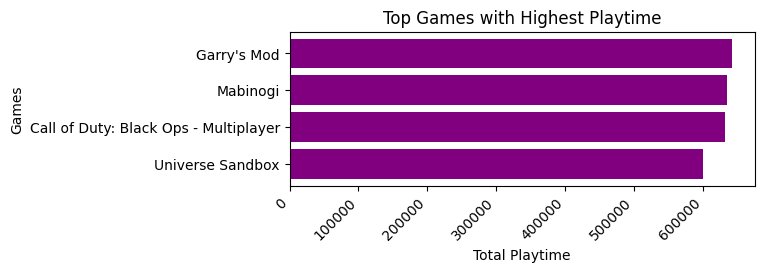

In [52]:
plt.figure(figsize=(6, 2))  # Adjust the plot size
# Plot the data
plt.barh(top_played_games['item_name'], top_played_games['playtime_forever'], color='purple')
plt.xlabel('Total Playtime')                        # X-axis label
plt.ylabel('Games')                                 # Y-axis label
plt.title('Top Games with Highest Playtime')        # Title of the plot

plt.gca().invert_yaxis()                            # Invert the Y-axis so that the game with the most playtime is at the top.
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability


# Show the plot
plt.show()

# Let’s explore the columns ‘sentiment_analysis’ and ‘recommend’:

sentiment_analysis: This column represents sentiment analysis. It utilizes natural language processing (NLP) to determine whether content is positive, negative, or neutral.
reviews_recommend: This column indicates whether users recommend the game. It contains boolean values (True or False) reflecting users’ opinions about the game.

In [53]:
# Number of users who expressed their opinion
print(f"Number of unique users who provided feedback: {len(df_reviews['user_id'].unique())}")

Number of unique users who provided feedback: 25458


In [54]:
def summary_count_percentage(df, column):
    counts = df_reviews[column].value_counts()
    percentages = round(100 * counts / len(df), 2)
    # Create a DataFrame with the summary
    df_summary = pd.DataFrame({
        "Count": counts,
        "Percentage": percentages
    })
    return df_summary

# Example usage:
Result_summary = summary_count_percentage(df_reviews, 'recommend')
print(Result_summary)

           Count  Percentage
recommend                   
True       51692       88.47
False       6739       11.53


In [55]:
summary_count_percentage(df_reviews, 'sentiment_analysis')

,Count,Percentage
sentiment_analysis,,
1,36714,62.83
2,16468,28.18
0,5249,8.98


This code snippet groups the data in the df_reviews DataFrame by the columns ‘sentiment_analysis’ and ‘recommend’. It then calculates the count and percentage of reviews in each group and creates a summary DataFrame called sentiment_recommendation_summary. The resulting summary will display the count and percentage for each combination of sentiment and recommendation

In [56]:
# Group by 'sentiment_analysis' and 'recommend'
df_grouped = df_reviews.groupby(['sentiment_analysis', 'recommend'])

# Count the number of reviews in each group
group_counts = df_grouped.size()

# Calculate the percentage for each group
group_percentages = 100 * df_grouped.size() / len(df_reviews)

# Create a DataFrame with the summary
sentiment_recommendation_summary = pd.DataFrame({
    "Count": group_counts,
    "Percentage": group_percentages
})

sentiment_recommendation_summary

Count  Percentage
sentiment_analysis recommend                   
0                  False       1124    1.923636
                   True        4125    7.059609
1                  False       4422    7.567901
                   True       32292   55.265185
2                  False       1193    2.041724
                   True       15275   26.141945

EDA del dataset df_steam

In [57]:
df_steam.head()

,genres,price,early_access,id,release_year,publisher,app_name,title,developer
0,Action,4.99,0.0,761140,2018,Kotoshiro,Lost Summoner Kitty,Lost Summoner Kitty,Kotoshiro
1,Casual,4.99,0.0,761140,2018,Kotoshiro,Lost Summoner Kitty,Lost Summoner Kitty,Kotoshiro
2,Indie,4.99,0.0,761140,2018,Kotoshiro,Lost Summoner Kitty,Lost Summoner Kitty,Kotoshiro
3,Simulation,4.99,0.0,761140,2018,Kotoshiro,Lost Summoner Kitty,Lost Summoner Kitty,Kotoshiro
4,Strategy,4.99,0.0,761140,2018,Kotoshiro,Lost Summoner Kitty,Lost Summoner Kitty,Kotoshiro


Counting Records and Checking Data Types and Null Values

In [58]:
# Calculate the total number of records
print(f'Total number of records: {df_steam.shape[0]}')

# Verify data types and check for null values
def ddbb_verification(df_steam):
    mi_dict = {"name": [], "tipe": [], "no_nulls_%": [], "nulls_%": [], "nulls": []}

    for column in df_steam.columns:
        porcentaje_no_nulls = (df_steam[column].count() / len(df_steam)) * 100
        mi_dict["name"].append(column)
        mi_dict["tipe"].append(df_steam[column].apply(type).unique())
        mi_dict["no_nulls_%"].append(round(porcentaje_no_nulls, 2))
        mi_dict["nulls_%"].append(round(100 - porcentaje_no_nulls, 2))
        mi_dict["nulls"].append(df_steam[column].isnull().sum())

    df_info = pd.DataFrame(mi_dict)
    return df_info

# Call the function
df_steam_info = ddbb_verification(df_steam)
print(df_steam_info)


Total number of records: 71554
           name                              tipe  no_nulls_%  nulls_%  nulls
0        genres                   [<class 'str'>]      100.00     0.00      0
1         price                 [<class 'float'>]      100.00     0.00      0
2  early_access                 [<class 'float'>]      100.00     0.00      0
3            id                   [<class 'int'>]      100.00     0.00      0
4  release_year                   [<class 'str'>]      100.00     0.00      0
5     publisher  [<class 'str'>, <class 'float'>]       99.93     0.07     47
6      app_name                   [<class 'str'>]      100.00     0.00      0
7         title                   [<class 'str'>]      100.00     0.00      0
8     developer                   [<class 'str'>]      100.00     0.00      0


# Column 'id', 'app_name' and 'title'

In [59]:
# These columns refer to the unique game identifier and the application and game title names. The latter two do not have significant information to analyze at this moment. Using the 'id', we can calculate the total number of games.

total_games = len(df_steam['id'].unique())
print(f"The total number of registered games is: {total_games}")

The total number of registered games is: 28851


# Columna 'genres'

Genres and count of games 

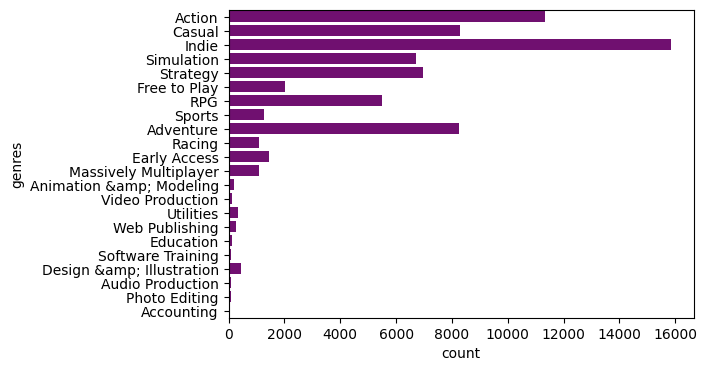

In [60]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_steam, y='genres', orient='h', color='purple')
plt.show()

# Number of game releases per year 

In [61]:
# Let's analyze which months have the most game releases.

# Make a copy of the original DataFrame df_steam
df_steam_copy = df_steam.copy()

# Calculate the number of games released per year
games_per_year = df_steam_copy.groupby('release_year').size().reset_index(name='game_count')

# Now you have the game release counts per year in the DataFrame games_per_year
print(games_per_year)

         release_year  game_count
0                1983           3
1                1984           5
2                1985           1
3                1986           5
4                1987           5
5                1988           9
6                1989          11
7                1990          14
8                1991          22
9                1992          24
10               1993          40
11               1994          52
12               1995          49
13               1996          56
14               1997          64
15               1998          75
16               1999          80
17               2000          55
18               2001         109
19               2002          62
20               2003         118
21               2004          92
22               2005         139
23               2006         217
24               2007         259
25               2008         332
26               2009         486
27               2010         653
28            

In [62]:
# Sort the DataFrame by game counts in descending order
top_5_years = games_per_year.sort_values(by='game_count', ascending=False).head(5)
print(top_5_years)

   release_year  game_count
34         2017       24968
33         2016       17667
32         2015       12256
31         2014        6341
30         2013        3016


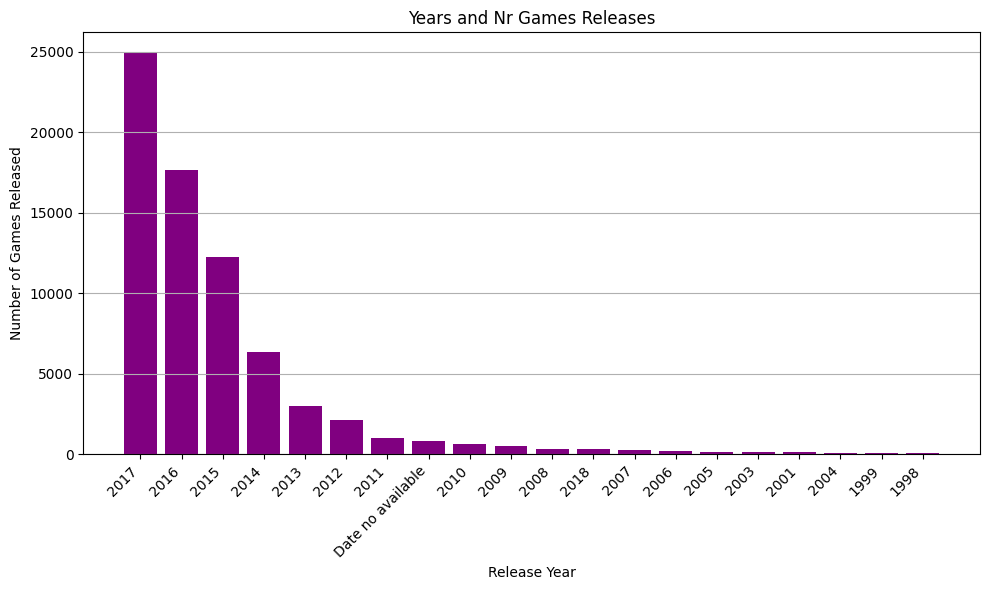

In [72]:
# Convert the release_year column to a string format
games_per_year['release_year'] = games_per_year['release_year'].astype(str)

# Sort the DataFrame by game counts in descending order
top_5_years = games_per_year.sort_values(by='game_count', ascending=False).head(20)

# Create a bar plot to visualize the top 5 years
plt.figure(figsize=(10, 6))
plt.bar(top_5_years['release_year'], top_5_years['game_count'], color='purple')
plt.xlabel('Release Year')
plt.ylabel('Number of Games Released')
plt.title('Years and Nr Games Releases')
plt.grid(axis='y')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust spacing

# Show the plot
plt.show()

# Column 'publisher' and 'developer'

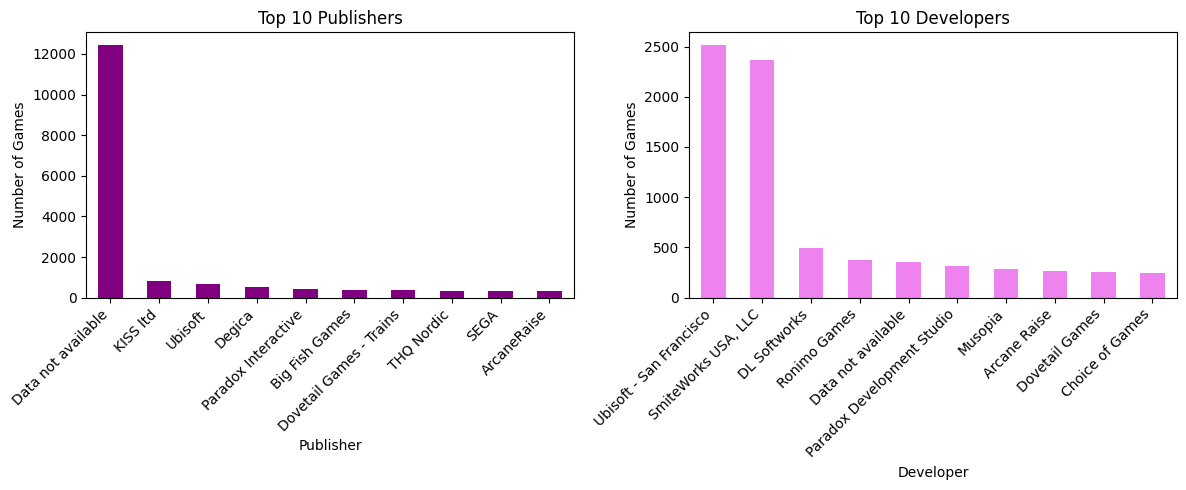

In [64]:
# Count the number of games per publisher
publisher_counts = df_steam['publisher'].value_counts()

# Count the number of games per developer
developer_counts = df_steam['developer'].value_counts()

# Create a figure with two subplots side by side
plt.figure(figsize=(12, 5))

# First subplot for publishers
plt.subplot(1, 2, 1)
publisher_counts[:10].plot(kind='bar', color='purple')
plt.xlabel('Publisher')
plt.ylabel('Number of Games')
plt.title('Top 10 Publishers')
plt.xticks(rotation=45, ha='right')
# Second subplot for developers
plt.subplot(1, 2, 2)
developer_counts[:10].plot(kind='bar', color='violet')
plt.xlabel('Developer')
plt.ylabel('Number of Games')
plt.title('Top 10 Developers')

# Display and adjust spacing between subplots
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Column 'price'
The describe() method calculates summary statistics for the unique game prices, including measures like median, mean, quartiles, and more.
We print the median (50th percentile) price, mean (average) price, and the 75th percentile price (price below which 75% of games fall).

In [65]:
# Obtains prices for each game and creates a DataFrame
unique_prices = df_steam.groupby('id')['price'].unique().reset_index().explode('price')
df_unique_prices = unique_prices['price']


# Calculate statistics for the unique game prices
statistics = df_unique_prices.astype(float).describe()

# Print the median price of games
print(f"The median price of games is: {statistics['50%']}")

# Print the mean price of games (average)
print(f"The mean price of games is: {round(statistics['mean'], 2)}")

# Print the 75th percentile price (price below which 75% of games fall)
print(f"75% of games have a price lower than: {statistics['75%']}")


The median price of games is: 4.99
The mean price of games is: 8.62
75% of games have a price lower than: 9.99


**Price Distribution:**

The analysis reveals the distribution of game prices.
Approximately 50% of the games fall within the price range of $0 to $4.99.
The median (50th percentile) price lies within this range.
This suggests that a significant portion of games are priced affordably or even offered for free.

75th Percentile Price:
The 75th percentile represents the price below which 75% of the games fall.
In this case, the 75th percentile price is below $9.99.
Most games are priced below this threshold, indicating a common trend of keeping prices relatively low.

Outliers and Atypical Values:
There are 1746 values that can be considered atypical or outliers.
These outliers have prices exceeding $21.99.
While some of these high-priced games may be legitimate, there are also instances where prices exceed $250, which could be errors or anomalies.

Conclusion:
Overall, the game price distribution shows a mix of affordability and occasional extreme values.
Developers should carefully review and validate prices to avoid unintentional errors or unrealistic pricing.

# EDA del dataset df_items

In [66]:
#The number of records is calculated
print(f'The total number of records in the dataset is:{df_items.shape[0]}')

The total number of records in the dataset is:5094105


In [67]:
def ddbb_verification(df_items):
    mi_dict = {"name": [], "tipe": [], "no_nulls_%": [], "nulls_%": [], "nulls": []}

    for column in df_items.columns:
        porcentaje_no_nulls = (df_items[column].count() / len(df_items)) * 100
        mi_dict["name"].append(column)
        mi_dict["tipe"].append(df_items[column].apply(type).unique())
        mi_dict["no_nulls_%"].append(round(porcentaje_no_nulls, 2))
        mi_dict["nulls_%"].append(round(100 - porcentaje_no_nulls, 2))
        mi_dict["nulls"].append(df_items[column].isnull().sum())

    df_info = pd.DataFrame(mi_dict)
    return df_info

# Call the function
df_items_info = ddbb_verification(df_items)
print(df_items_info)

               name               tipe  no_nulls_%  nulls_%  nulls
0           item_id    [<class 'str'>]       100.0      0.0      0
1         item_name    [<class 'str'>]       100.0      0.0      0
2  playtime_forever  [<class 'float'>]       100.0      0.0      0
3           user_id    [<class 'str'>]       100.0      0.0      0
4       items_count    [<class 'int'>]       100.0      0.0      0
5          steam_id    [<class 'str'>]       100.0      0.0      0
6          user_url    [<class 'str'>]       100.0      0.0      0


# Playtime Hours!!
## Columna 'playtime_forever'

The code snippet calculates the playtime in hours (playtime_hours) from the original playtime data given in minutes (playtime_forever).
It creates a figure with two subplots:
The first subplot displays a strip plot showing the distribution of game playtime.
The second subplot displays a box plot to visualize the spread and outliers in playtime.
The x-axis represents playtime in hours, and the y-axis represents the number of games.
The tight layout ensures proper spacing between the subplots.

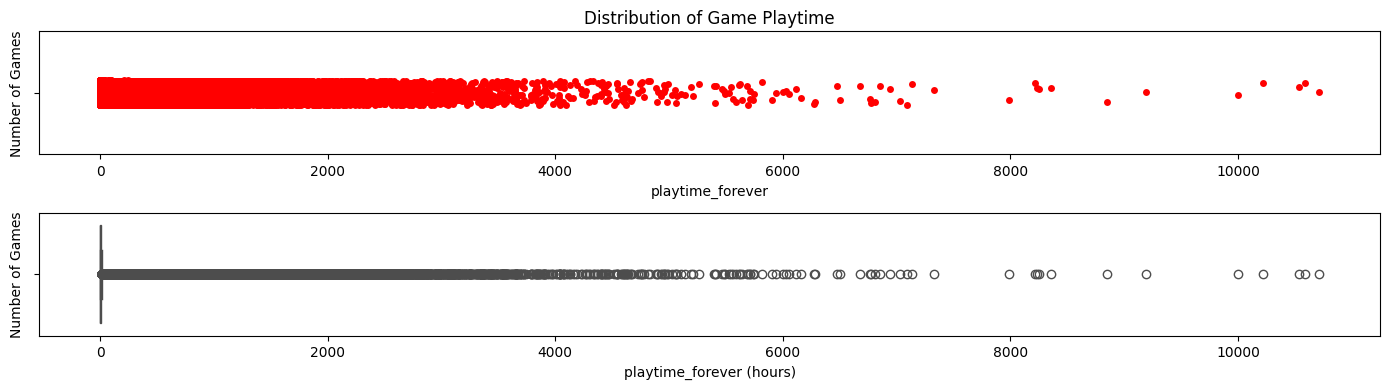

: 

In [83]:
# Calculate playtime in hours from playtime_forever (given in minutes)
df_items['playtime_hours'] = df_items['playtime_forever'] / 60

# Create a figure with two subplots
fig = plt.figure(figsize=(14, 4))

# First subplot for strip plot
ax1 = fig.add_subplot(211)
sns.stripplot(data=df_items, x='playtime_hours', ax=ax1, color='red')
ax1.set_xlabel('playtime_forever')
ax1.set_ylabel('Number of Games')
ax1.set_title('Distribution of Game Playtime')

# Second subplot for box plot
ax2 = fig.add_subplot(212, sharex=ax1)
sns.boxplot(data=df_items, x='playtime_hours', ax=ax2, color='red')
ax2.set_xlabel('playtime_forever (hours)')
ax2.set_ylabel('Number of Games')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

The describe() method calculates summary statistics for game playtime in hours.
We print the median playtime (50th percentile), mean playtime (average), and the 75th percentile playtime (playtime below which 75% of games fall).

In [73]:
# Calculate statistics for game playtime in hours
statistics = df_items['playtime_hours'].describe()

# Print the median playtime (middle value)
print(f"The median playtime of games is: {round(statistics['50%'], 2)} hours")

# Print the mean playtime (average)
print(f"The mean playtime of games is: {round(statistics['mean'], 2)} hours")

# Print the 75th percentile playtime (playtime below which 75% of games fall)
print(f"75% of games have a playtime lower than: {round(statistics['75%'], 2)} hours")


The median playtime of games is: 0.57 hours
The mean playtime of games is: 16.51 hours
75% of games have a playtime lower than: 5.92 hours


# Column 'items_count'

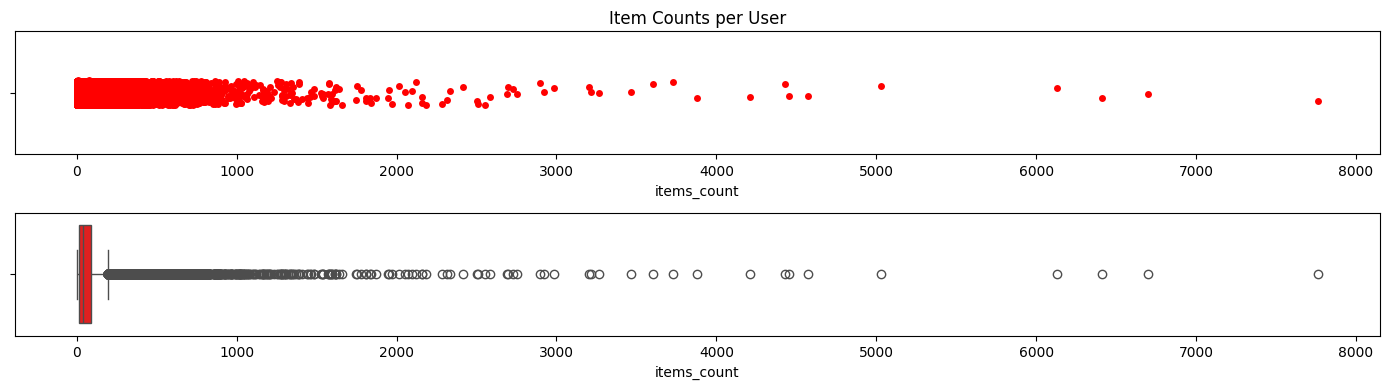

In [82]:
# Group the item count by user, convert it into a DataFrame, and sort it in descending order
items_count_user = df_items.groupby('user_id')['items_count'].unique().explode()
items_count_user = pd.DataFrame(items_count_user)
items_count_user_o = items_count_user.sort_values('items_count', ascending=False)

# Create a figure with two subplots
fig = plt.figure(figsize=(14, 4))

# First subplot: stripplot
ax1 = fig.add_subplot(211)
sns.stripplot(data=items_count_user_o, x='items_count', ax=ax1, color='red')
ax1.set_xlabel('items_count')
ax1.set_title('Item Counts per User')

# Second subplot: boxplot
ax2 = fig.add_subplot(212, sharex=ax1)
sns.boxplot(data=items_count_user_o, x='items_count', ax=ax2, color='red')
ax2.set_xlabel('items_count')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()


In [79]:
# Calculate statistics on the item count per user
statistics = items_count_user['items_count'].astype(float).describe()

# Print the results
print(f'The median item count is: {round(statistics.iloc[5], 2)}')
print(f'The mean item count is: {round(statistics.iloc[1], 2)}')
print(f'75% of users have an item count less than: {round(statistics.iloc[6], 2)}')

The median item count is: 40.0
The mean item count is: 71.84
75% of users have an item count less than: 87.0


<Figure size 1400x500 with 0 Axes>

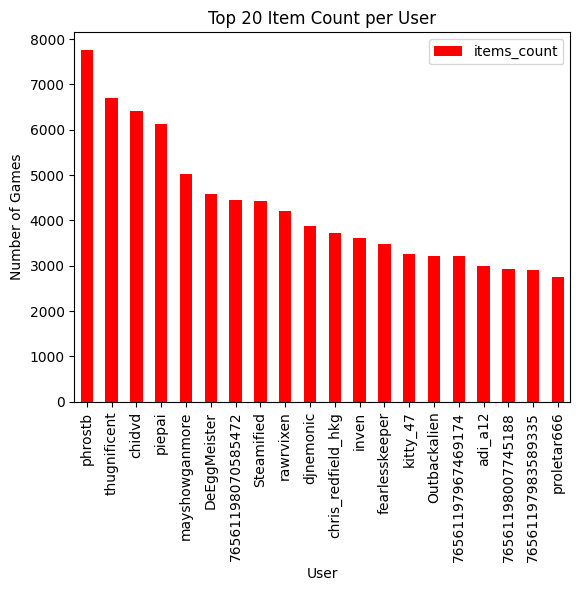

In [81]:
# Plot item count per user in descending order
plt.figure(figsize=(14, 5))
items_count_user_o[:20].plot(kind='bar', color='red')  # Use items_count_user_o instead of items_count_user
plt.xlabel('User')
plt.ylabel('Number of Games')
plt.title('Top 20 Item Count per User')
plt.show()


####checkkkkkkkkkkkk


# We took a random sample to test the feature that recommends 3 games based on their game id, based on tags and similar genres.

In [74]:
# Specify the sample size
sample_size = 100

# Take a random sample from the original DataFrame
random_sample = df_steam.sample(n=sample_size, random_state=42)

# Get the game with the user-provided item_id
user_item_id = 50  # Replace with the user-provided item_id
target_game = random_sample[random_sample['id'] == user_item_id]

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Apply the vectorizer to the reference game and all other games using 'genres' column
tfidf_matrix = tfidf_vectorizer.fit_transform([target_game['genres'].fillna('').astype(str)] + random_sample['genres'].fillna('').astype(str).tolist())

# Calculate similarity between the reference game and all other games
similarity_matrix = cosine_similarity(tfidf_matrix)

# Sort games by similarity and get indices of the most similar games
similar_games_indices = similarity_matrix[0].argsort()[::-1]

# Recommend the most similar games
num_recommendations = 3
recommended_games = random_sample.reset_index(drop=True).loc[similar_games_indices[1:num_recommendations + 1]]

# Return the list of recommended games
recommended_games


AttributeError: 'Series' object has no attribute 'lower'

In [70]:
# Specify the sample size
sample_size = 100

# Take a random sample from the original DataFrame
random_sample = df_steam.sample(n=sample_size, random_state=42)

# Get the game with the user-provided item_id
user_item_id = 50                                                       # Replace with the user-provided item_id

target_game = random_sample[random_sample['id'] == user_item_id]

# Combine tags and genres into a single text string
# Clean null values in the 'tags' and 'genres' columns and convert everything to text strings
target_game_tags_and_genres = ' '.join(target_game['tags'].fillna('').astype(str) + ' ' + target_game['genres'].fillna('').astype(str))

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Apply the vectorizer to the reference game and all other games
# Clean null values in the 'tags' and 'genres' columns and convert everything to text strings
random_sample['tags_and_genres'] = random_sample['tags'].fillna('').astype(str) + ' ' + random_sample['genres'].fillna('').astype(str)
tfidf_matrix = tfidf_vectorizer.fit_transform([target_game_tags_and_genres] + random_sample['tags_and_genres'].tolist())

# Calculate similarity between the reference game and all other games
similarity_matrix = cosine_similarity(tfidf_matrix)

# Sort games by similarity and get indices of the most similar games
similar_games_indices = similarity_matrix[0].argsort()[::-1]

# Recommend the most similar games 
num_recommendations = 3
recommended_games = random_sample.reset_index(drop=True).loc[similar_games_indices[1:num_recommendations + 1]]

# Return the list of recommended games
recommended_games



KeyError: 'tags'

In [ ]:
# Create a nice table using tabulate
table_data = recommended_games[["app_name", "developer"]].values.tolist()
table = tabulate(table_data, tablefmt="fancy_grid")

# Print the table
print(table)

NameError: name 'recommended_games' is not defined